In [1]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import os

2021-09-17 18:52:21.249769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-17 18:52:21.249794: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from pandas.errors import EmptyDataError
def prepare_tuple_dataset(dataset_root_folder="thoughts"):
    signals = []
    labels = []
    bad_files = []
    class_folders = os.listdir(dataset_root_folder) #folders of seperate signals like left,right and pick_object
    #timeframe_starrt and timeframe_end selects from which sample to which sample
    # should be used for training and evaluation 
    timeframe_start = 251 #from which sample to st
    timeframe_end = 1501
    for class_folder in class_folders:
        print(f"In folder {class_folder}")
        if class_folder == ".ipynb_checkpoints" or class_folder == "pick_object":
            continue
        for file in tqdm(os.listdir(dataset_root_folder+"/"+class_folder)):
            file_name = dataset_root_folder+"/"+class_folder+"/"+file 
            if file == ".ipynb_checkpoints":
                continue
            else:
                try:
                    tmp_dataset = pd.read_csv(file_name,skiprows=6,header=None)
                    tmp_dataset=tmp_dataset.iloc[timeframe_start:timeframe_end,1:9]
                    if tmp_dataset.shape[0] < (timeframe_end-timeframe_start):
                        continue
                    signals.append(tmp_dataset.T.to_numpy().reshape(8,1250))
                    labels.append(np.array(1 if class_folder == "left" else 0).reshape(1,1))
                except EmptyDataError:
                    bad_files.append(file_name)
    if bad_files != []:
        print("Following files have no data in columns to parse")
        print(bad_files)
            
    return signals,labels
signals,labels = prepare_tuple_dataset("nishanth_thoughts")


In folder right


100%|███████████████████████████████████████████████████████████████████████| 333/333 [00:04<00:00, 68.86it/s]


In folder left


100%|███████████████████████████████████████████████████████████████████████| 491/491 [00:12<00:00, 39.29it/s]


Left: 58.35443037974684%
Right: 41.64556962025316%


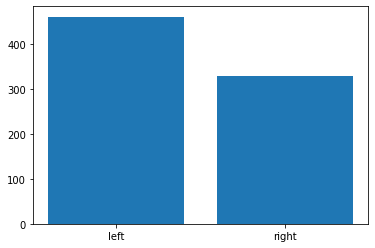

In [4]:
total_len = len(labels)
left = [x for x in labels if x == 1]
right = [x for x in labels if x == 0]
left_pct = len(left)/total_len*100
right_pct = len(right)/total_len*100
print(f"Left: {left_pct}%")
print(f"Right: {right_pct}%")
plt.bar(["left","right"],[len(left),len(right)])
plt.show()

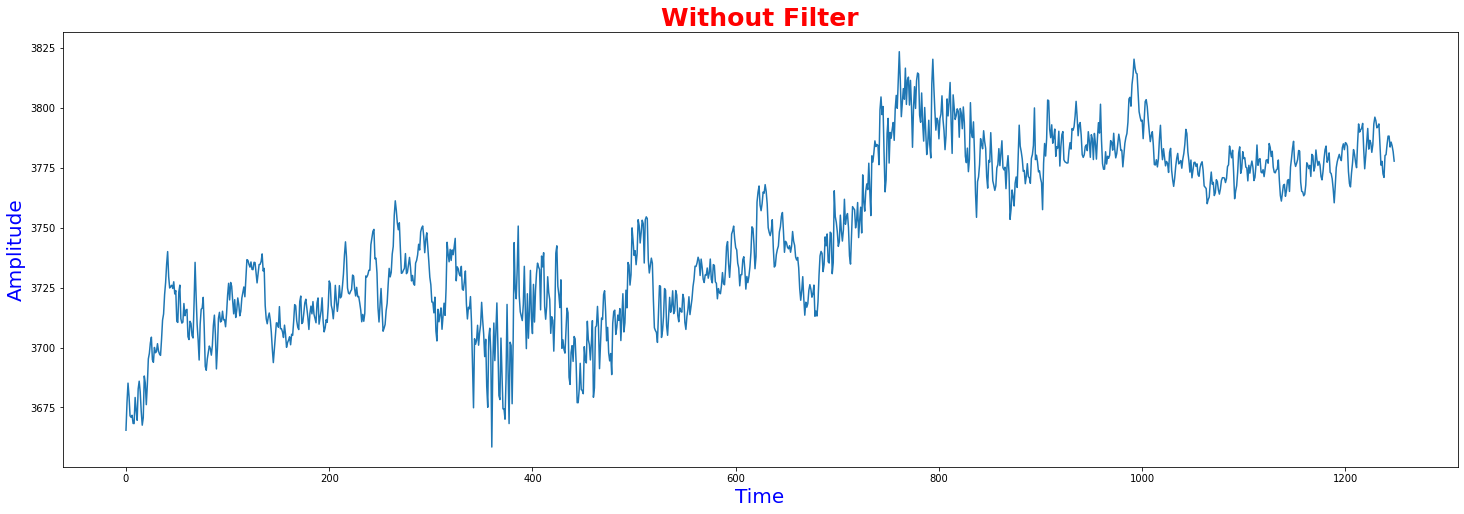

In [5]:
def plot_wave_form(signal,xlabel="Time",ylabel="Amplitude",title="",stop_at=-1):
    plt.figure(figsize=(25,8))
    plt.plot(signal[:stop_at])
    plt.xlabel(xlabel,fontdict={"color":"blue","fontsize":20})
    plt.ylabel(ylabel,fontdict={"color":"blue","fontsize":20})
    plt.title(title,fontdict={"color":"red","fontweight":"bold","fontsize":25})
    plt.show()
    
plot_wave_form(signals[50][1],title="Without Filter",stop_at=-1)

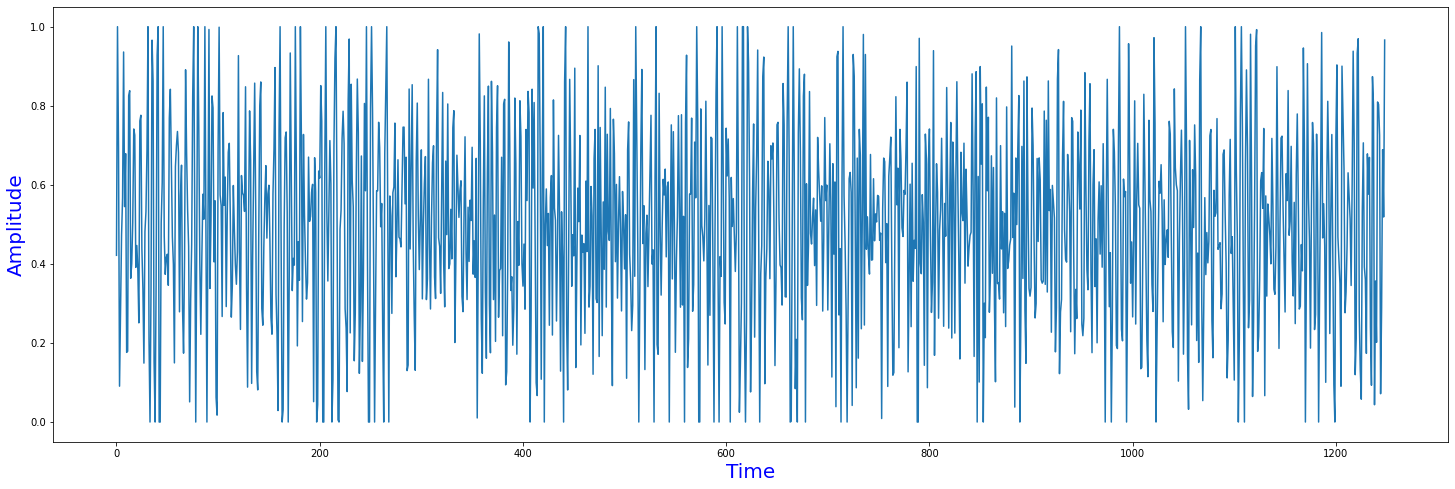

In [6]:
from scipy.signal import butter,filtfilt,sosfiltfilt
from scipy.signal import iirnotch
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sample_period = 5
sample_frequency = 250
band_start = 0.15
band_stop = 0.5
order=9
def butter_bandpass_filter(signal,fs,order,band=[30,100]):
    nyq = fs*0.5
    start_cutoff = band[0]/nyq
    stop_cutoff = band[1]/nyq
    sos = butter(order,[start_cutoff,stop_cutoff],btype="bp",output="sos")
    y = sosfiltfilt(sos,signal)
    return y
def butter_highpass_filter(signal,fs,order,frequency=30):
    nyq = fs*0.5
    cutoff = frequency/nyq
    sos = butter(order,cutoff,btype="hp",output="sos")
    y = sosfiltfilt(sos,signal)
    return y
def notch_filter(signal,fs,order,notch_freq):
    nyq = fs*0.5
    quality_factor=20.0
#     cutoff = notch_freq/nyq
    b_notch,a_notch = iirnotch(notch_freq,quality_factor,fs)
    y = filtfilt(b_notch,a_notch,signal,)
    return y
def filter_signals(signals):
    filtered_signals = []
    for signal in signals:
        filtered_channels=[]
        for channel in signal:
            filtered_channel=butter_highpass_filter(np.array(channel).astype("float32"), sample_frequency, order, 30)
#             filtered_channels.append(scaler.fit_transform(np.array(channel).astype("float32").reshape(1250)).reshape(1250))
            filtered_channels.append(filtered_channel)
        scaler = MinMaxScaler()
        filtered_signals.append(scaler.fit_transform(np.array(filtered_channels)))
   
    return filtered_signals

filtered_signals = filter_signals(signals)
plot_wave_form(filtered_signals[50][1],stop_at=-1)
# filtered_signals=signals

### Required Statistical Parameters from signal
- Mean
- Maximum Amplitude 
- Minimum Amplitude
- Standard Deviation
- Variance
- RMS
- Entropy
- Kurtosis
- Skewness 
- Percentile
- Median 

In [7]:
import numpy as np
from scipy.stats import skew,kurtosis
from librosa.feature import spectral_centroid
from sklearn.preprocessing import StandardScaler
def calculate_statistical_parameters(signals):
    parameters = []
    
    for signal in tqdm(signals):
        channel_parametrs = []
        i=0
        for channel in signal:
            channel = np.array(channel).astype("float32")
            i = i+1
            max_amp = tf.convert_to_tensor(np.max(channel),"double")
            min_amp  = tf.convert_to_tensor(np.min(channel),"double")
            mean  = tf.convert_to_tensor(np.mean(channel),"double")
            median  = tf.convert_to_tensor(np.median(channel),"double")
            std_dev  = tf.convert_to_tensor(np.std(channel),"double")
            var = tf.convert_to_tensor(np.var(channel),"double")
            rms = tf.convert_to_tensor(np.sqrt(np.mean((channel-mean)**2)),"double")
            kurtosis_val=tf.convert_to_tensor(kurtosis(channel),"double")
            skew_val = tf.convert_to_tensor(skew(channel),"double")
            percentile=tf.convert_to_tensor(np.percentile(channel,100),"double")
#             scaler = StandardScaler()
            data = [max_amp, min_amp,mean,median,std_dev,var,rms,kurtosis_val,skew_val,percentile]
            channel_parametrs.append(tf.convert_to_tensor(data))
        parameters.append(channel_parametrs)
    return parameters

signal_parameters = calculate_statistical_parameters(filtered_signals)

  0%|                                                                                 | 0/790 [00:00<?, ?it/s]2021-09-17 18:53:26.621157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-17 18:53:26.621192: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-17 18:53:26.621226: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (surya): /proc/driver/nvidia/version does not exist
2021-09-17 18:53:26.670471: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
signal_dataset=np.asarray(signal_parameters)
reshaped_data=[]
for i in range(len(signal_dataset)):
    reshaped_data.append(tf.convert_to_tensor(np.expand_dims(signal_dataset[i],-1)))
x_train,x_test,y_train,y_test = train_test_split(reshaped_data,labels,test_size=0.2)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
labels=np.asarray(labels)

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten,Dense,Dropout,InputLayer,Reshape,Bidirectional,Conv2D,MaxPool2D,BatchNormalization,LeakyReLU
from tensorflow.keras import Sequential
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.optimizers import Adam,SGD,Adamax
from tensorflow.keras.regularizers import L2
def build_model():
    model = Sequential([
        InputLayer((8,10,1)),
        Conv2D(16,(3,3),padding="same",input_shape=(8,10,1),kernel_initializer="he_normal"),
        BatchNormalization(),
        LeakyReLU(),
        Conv2D(32,(7,7),padding="same",kernel_initializer="he_normal",kernel_regularizer="l2"),
        BatchNormalization(),
        LeakyReLU(),
#         Dropout(0.2),
        Conv2D(64,(7,7),padding="same",kernel_initializer="he_normal",kernel_regularizer="l1"),
        BatchNormalization(),
        LeakyReLU(),
#         Dropout(0.2),
        Conv2D(128,(7,7),padding="same",kernel_initializer="he_normal",kernel_regularizer="l1"),
        BatchNormalization(),
        LeakyReLU(),
        Flatten(),
        Dense(32,activation="leaky_relu",kernel_initializer="he_normal",kernel_regularizer="l1"),
        Dense(1,activation="sigmoid",name="output_layer"),
    ])
    model.compile(loss="binary_crossentropy",optimizer=Adam(0.00004),metrics=["accuracy"])
    return model
model = build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 8, 10, 16)         160       
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 10, 16)         64        
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8, 10, 16)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 10, 32)         25120     
_________________________________________________________________
batch_normalization_21 (Batc (None, 8, 10, 32)         128       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 8, 10, 32)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 10, 64)        

In [44]:
history=model.fit(x_train,y_train,epochs=300,validation_data=(x_test,y_test),batch_size=64)

Epoch 1/300
10/10 [==============================] - 2s 138ms/step - loss: 150.4026 - accuracy: 0.6044 - val_loss: 148.8640 - val_accuracy: 0.6013
Epoch 2/300
10/10 [==============================] - 1s 128ms/step - loss: 147.5593 - accuracy: 0.6867 - val_loss: 146.0619 - val_accuracy: 0.7342
Epoch 3/300
10/10 [==============================] - 1s 127ms/step - loss: 144.7362 - accuracy: 0.7326 - val_loss: 143.2875 - val_accuracy: 0.8354
Epoch 4/300
10/10 [==============================] - 1s 125ms/step - loss: 141.9480 - accuracy: 0.7785 - val_loss: 140.5139 - val_accuracy: 0.6139
Epoch 5/300
10/10 [==============================] - 1s 122ms/step - loss: 139.1730 - accuracy: 0.8307 - val_loss: 137.7632 - val_accuracy: 0.7532
Epoch 6/300
10/10 [==============================] - 1s 120ms/step - loss: 136.4189 - accuracy: 0.8513 - val_loss: 135.0200 - val_accuracy: 0.8038
Epoch 7/300
10/10 [==============================] - 2s 156ms/step - loss: 133.6911 - accuracy: 0.8402 - val_loss: 132

Epoch 57/300
10/10 [==============================] - 2s 158ms/step - loss: 41.8856 - accuracy: 0.9241 - val_loss: 41.3492 - val_accuracy: 0.8987
Epoch 58/300
10/10 [==============================] - 2s 159ms/step - loss: 40.8190 - accuracy: 0.9335 - val_loss: 40.3120 - val_accuracy: 0.8987
Epoch 59/300
10/10 [==============================] - 2s 158ms/step - loss: 39.7807 - accuracy: 0.9304 - val_loss: 39.2689 - val_accuracy: 0.9241
Epoch 60/300
10/10 [==============================] - 2s 156ms/step - loss: 38.7605 - accuracy: 0.9367 - val_loss: 38.2652 - val_accuracy: 0.9051
Epoch 61/300
10/10 [==============================] - 2s 158ms/step - loss: 37.7684 - accuracy: 0.9304 - val_loss: 37.3029 - val_accuracy: 0.9051
Epoch 62/300
10/10 [==============================] - 2s 158ms/step - loss: 36.8017 - accuracy: 0.9320 - val_loss: 36.3251 - val_accuracy: 0.9304
Epoch 63/300
10/10 [==============================] - 2s 158ms/step - loss: 35.8501 - accuracy: 0.9304 - val_loss: 35.3938 -

10/10 [==============================] - 2s 225ms/step - loss: 8.9723 - accuracy: 0.9241 - val_loss: 8.9088 - val_accuracy: 0.9051
Epoch 114/300
10/10 [==============================] - 2s 233ms/step - loss: 8.7026 - accuracy: 0.9351 - val_loss: 8.6533 - val_accuracy: 0.9051
Epoch 115/300
10/10 [==============================] - 2s 244ms/step - loss: 8.4597 - accuracy: 0.9320 - val_loss: 8.4059 - val_accuracy: 0.9177
Epoch 116/300
10/10 [==============================] - 2s 245ms/step - loss: 8.2102 - accuracy: 0.9351 - val_loss: 8.1753 - val_accuracy: 0.8924
Epoch 117/300
10/10 [==============================] - 3s 299ms/step - loss: 7.9759 - accuracy: 0.9241 - val_loss: 7.9310 - val_accuracy: 0.9177
Epoch 118/300
10/10 [==============================] - 2s 214ms/step - loss: 7.7404 - accuracy: 0.9335 - val_loss: 7.6932 - val_accuracy: 0.9177
Epoch 119/300
10/10 [==============================] - 2s 215ms/step - loss: 7.5083 - accuracy: 0.9462 - val_loss: 7.4714 - val_accuracy: 0.9304

10/10 [==============================] - 2s 240ms/step - loss: 2.3062 - accuracy: 0.9541 - val_loss: 2.3489 - val_accuracy: 0.9114
Epoch 170/300
10/10 [==============================] - 2s 240ms/step - loss: 2.2612 - accuracy: 0.9589 - val_loss: 2.2727 - val_accuracy: 0.9557
Epoch 171/300
10/10 [==============================] - 2s 208ms/step - loss: 2.2566 - accuracy: 0.9225 - val_loss: 2.2402 - val_accuracy: 0.9304
Epoch 172/300
10/10 [==============================] - 2s 204ms/step - loss: 2.2204 - accuracy: 0.9288 - val_loss: 2.1982 - val_accuracy: 0.9241
Epoch 173/300
10/10 [==============================] - 2s 201ms/step - loss: 2.1928 - accuracy: 0.9320 - val_loss: 2.2069 - val_accuracy: 0.9114
Epoch 174/300
10/10 [==============================] - 2s 206ms/step - loss: 2.1489 - accuracy: 0.9225 - val_loss: 2.1451 - val_accuracy: 0.9177
Epoch 175/300
10/10 [==============================] - 2s 205ms/step - loss: 2.1443 - accuracy: 0.8987 - val_loss: 2.1600 - val_accuracy: 0.9051

10/10 [==============================] - 2s 199ms/step - loss: 1.0258 - accuracy: 0.9699 - val_loss: 1.0735 - val_accuracy: 0.9430
Epoch 226/300
10/10 [==============================] - 2s 199ms/step - loss: 1.0202 - accuracy: 0.9715 - val_loss: 1.0558 - val_accuracy: 0.9557
Epoch 227/300
10/10 [==============================] - 2s 211ms/step - loss: 1.0244 - accuracy: 0.9652 - val_loss: 1.1202 - val_accuracy: 0.9114
Epoch 228/300
10/10 [==============================] - 2s 205ms/step - loss: 1.0204 - accuracy: 0.9589 - val_loss: 1.0989 - val_accuracy: 0.9051
Epoch 229/300
10/10 [==============================] - 2s 208ms/step - loss: 0.9943 - accuracy: 0.9715 - val_loss: 1.0250 - val_accuracy: 0.9557
Epoch 230/300
10/10 [==============================] - 2s 221ms/step - loss: 0.9792 - accuracy: 0.9731 - val_loss: 1.0303 - val_accuracy: 0.9367
Epoch 231/300
10/10 [==============================] - 2s 212ms/step - loss: 0.9768 - accuracy: 0.9652 - val_loss: 1.0735 - val_accuracy: 0.9114

10/10 [==============================] - 2s 199ms/step - loss: 0.7422 - accuracy: 0.9731 - val_loss: 0.8227 - val_accuracy: 0.9177
Epoch 282/300
10/10 [==============================] - 2s 202ms/step - loss: 0.7496 - accuracy: 0.9731 - val_loss: 0.8806 - val_accuracy: 0.9051
Epoch 283/300
10/10 [==============================] - 2s 202ms/step - loss: 0.7590 - accuracy: 0.9684 - val_loss: 0.8346 - val_accuracy: 0.9241
Epoch 284/300
10/10 [==============================] - 2s 201ms/step - loss: 0.7518 - accuracy: 0.9684 - val_loss: 0.8324 - val_accuracy: 0.9177
Epoch 285/300
10/10 [==============================] - 2s 199ms/step - loss: 0.7444 - accuracy: 0.9747 - val_loss: 0.7837 - val_accuracy: 0.9557
Epoch 286/300
10/10 [==============================] - 2s 202ms/step - loss: 0.7379 - accuracy: 0.9747 - val_loss: 0.7789 - val_accuracy: 0.9557
Epoch 287/300
10/10 [==============================] - 2s 209ms/step - loss: 0.7270 - accuracy: 0.9778 - val_loss: 0.8165 - val_accuracy: 0.9241

In [45]:
def plot_loss_accuracy_chart(history,validation=True):
    plt.plot(history.history['accuracy'])
    if validation==True:
        plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    if validation==True:
        plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

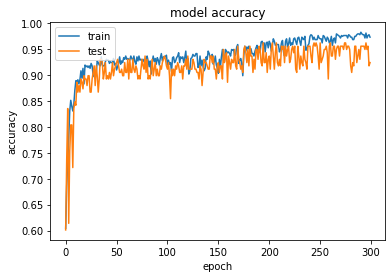

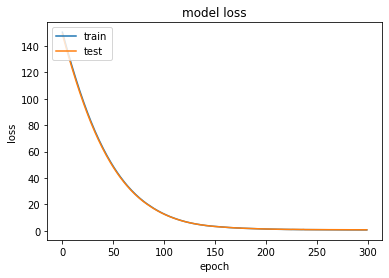

In [46]:
plot_loss_accuracy_chart(history)

In [47]:
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score
y_true = []
for label in y_test:
    y_true.append(label.reshape(1))
y_predictions=model.predict(x_test).astype("float32")
y_predictions=np.where(y_predictions > 0.50002,1,0)
def print_metrics(y_true,y_predictions):
    print("Confusion Matrix:\n ",confusion_matrix(y_true,y_predictions))
    print("Accuracy Score: ",accuracy_score(y_true,y_predictions))
    print("ROC AUC Score: ",roc_auc_score(y_true,y_predictions))
print_metrics(y_true,y_predictions)

Confusion Matrix:
  [[61  2]
 [10 85]]
Accuracy Score:  0.9240506329113924
ROC AUC Score:  0.9314954051796158


In [38]:
tf.keras.models.save_model(model,"./binary-model")

INFO:tensorflow:Assets written to: ./binary-model/assets


In [39]:
model = tf.keras.models.load_model("binary-model")

In [40]:
def preprocess_test_data(dataset_root_folder="test_dataset",sample_frequency=250,order=9,band=[30,100],test_size=0.3):
    signals,labels = prepare_tuple_dataset(dataset_root_folder)
    filtered_signals=filter_signals(signals)
    signal_parameters=calculate_statistical_parameters(signals)
    signal_dataset=np.asarray(signal_parameters)
    reshaped_data = []
    for i in range(len(signal_dataset)):
        reshaped_data.append(tf.convert_to_tensor(np.expand_dims(signal_dataset[i],-1)))
    return np.array(reshaped_data),labels

In [42]:
def test_samples(model,signals,true_labels):
    y_true=[]
    for label in true_labels:
        y_true.append(label.reshape(1))
    y_predictions=model.predict(signals).astype("float32")
    y_predictions = np.where(y_predictions > 0.50002,1,0)
    print_metrics(y_true,y_predictions)
    return y_true,y_predictions

signals,labels = preprocess_test_data("nishanth_test_thoughts")
y_true,y_predictions=test_samples(model,signals,labels)  

In folder right


100%|████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 189.15it/s]


In folder left


100%|█████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 94.31it/s]


Confusion Matrix:
  [[48  3]
 [ 0 37]]
Accuracy Score:  0.9659090909090909
ROC AUC Score:  0.9705882352941176


In [17]:
from sklearn.model_selection import KFold,StratifiedKFold
num_folds = 10
fold_no=1
kfold = KFold(n_splits=num_folds, shuffle=True)
signals,labels = prepare_tuple_dataset()
filtered_signals = filter_signals(signals)
signal_parameters = np.array(calculate_statistical_parameters(filtered_signals))
signal_parameters = np.expand_dims(signal_parameters,-1)
labels = np.array(labels)
acc_per_fold=[]
loss_per_fold=[]
for train,test in kfold.split(signal_parameters,labels):
    model = build_model()
    model.fit(signal_parameters[train.astype("int")],labels[train.astype("int")],batch_size=16,epochs=200)
     # Generate generalization metrics
    scores = model.evaluate(signal_parameters[test.astype("int")], labels[test.astype("int")], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

In folder .ipynb_checkpoints
In folder right


100%|███████████████████████████████████████████████████████████████████████| 456/456 [00:09<00:00, 48.40it/s]


In folder left


100%|███████████████████████████████████████████████████████████████████████| 588/588 [00:14<00:00, 40.29it/s]


In folder pick_object
Following files have no data in columns to parse
['thoughts/right/OpenBCI-RAW-2021-09-08_15-40-15.txt', 'thoughts/left/OpenBCI-RAW-2021-09-08_13-08-56.txt']


100%|█████████████████████████████████████████████████████████████████████| 1002/1002 [00:14<00:00, 69.06it/s]


Epoch 1/200
57/57 [==============================] - 5s 69ms/step - loss: 148.8416 - accuracy: 0.7125
Epoch 2/200
57/57 [==============================] - 4s 69ms/step - loss: 142.2751 - accuracy: 0.8058
Epoch 3/200
57/57 [==============================] - 4s 62ms/step - loss: 135.7620 - accuracy: 0.8446
Epoch 4/200
57/57 [==============================] - 4s 62ms/step - loss: 129.3444 - accuracy: 0.8613
Epoch 5/200
57/57 [==============================] - 4s 71ms/step - loss: 123.0653 - accuracy: 0.8646
Epoch 6/200
57/57 [==============================] - 4s 76ms/step - loss: 116.9437 - accuracy: 0.8912
Epoch 7/200
57/57 [==============================] - 4s 65ms/step - loss: 111.0346 - accuracy: 0.8868
Epoch 8/200
57/57 [==============================] - 4s 68ms/step - loss: 105.3141 - accuracy: 0.8912
Epoch 9/200
57/57 [==============================] - 4s 69ms/step - loss: 99.8150 - accuracy: 0.9012
Epoch 10/200
57/57 [==============================] - 4s 63ms/step - loss: 94.5008 

57/57 [==============================] - 3s 46ms/step - loss: 0.5684 - accuracy: 0.9623
Epoch 162/200
57/57 [==============================] - 3s 50ms/step - loss: 0.5633 - accuracy: 0.9623
Epoch 163/200
57/57 [==============================] - 3s 49ms/step - loss: 0.5573 - accuracy: 0.9600
Epoch 164/200
57/57 [==============================] - 3s 48ms/step - loss: 0.5696 - accuracy: 0.9523
Epoch 165/200
57/57 [==============================] - 3s 47ms/step - loss: 0.5536 - accuracy: 0.9600
Epoch 166/200
57/57 [==============================] - 3s 47ms/step - loss: 0.5637 - accuracy: 0.9545
Epoch 167/200
57/57 [==============================] - 3s 46ms/step - loss: 0.5589 - accuracy: 0.9578
Epoch 168/200
57/57 [==============================] - 3s 58ms/step - loss: 0.5578 - accuracy: 0.9589
Epoch 169/200
57/57 [==============================] - 3s 51ms/step - loss: 0.5557 - accuracy: 0.9489
Epoch 170/200
57/57 [==============================] - 3s 55ms/step - loss: 0.5562 - accuracy: 0

Epoch 121/200
57/57 [==============================] - 3s 58ms/step - loss: 0.7587 - accuracy: 0.9467
Epoch 122/200
57/57 [==============================] - 3s 60ms/step - loss: 0.7589 - accuracy: 0.9489
Epoch 123/200
57/57 [==============================] - 3s 46ms/step - loss: 0.7569 - accuracy: 0.9401
Epoch 124/200
57/57 [==============================] - 3s 51ms/step - loss: 0.7344 - accuracy: 0.9523
Epoch 125/200
57/57 [==============================] - 3s 59ms/step - loss: 0.7252 - accuracy: 0.9489
Epoch 126/200
57/57 [==============================] - 3s 47ms/step - loss: 0.7237 - accuracy: 0.9501
Epoch 127/200
57/57 [==============================] - 3s 44ms/step - loss: 0.7104 - accuracy: 0.9501
Epoch 128/200
57/57 [==============================] - 3s 49ms/step - loss: 0.7168 - accuracy: 0.9489
Epoch 129/200
57/57 [==============================] - 3s 45ms/step - loss: 0.7187 - accuracy: 0.9401
Epoch 130/200
57/57 [==============================] - 3s 45ms/step - loss: 0.7092

57/57 [==============================] - 4s 51ms/step - loss: 148.1988 - accuracy: 0.7350
Epoch 2/200
57/57 [==============================] - 3s 50ms/step - loss: 141.1031 - accuracy: 0.8415
Epoch 3/200
57/57 [==============================] - 3s 48ms/step - loss: 134.2266 - accuracy: 0.8537
Epoch 4/200
57/57 [==============================] - 3s 50ms/step - loss: 127.5355 - accuracy: 0.8836
Epoch 5/200
57/57 [==============================] - 4s 77ms/step - loss: 121.1085 - accuracy: 0.8747
Epoch 6/200
57/57 [==============================] - 3s 61ms/step - loss: 114.8760 - accuracy: 0.8936
Epoch 7/200
57/57 [==============================] - 4s 68ms/step - loss: 108.9227 - accuracy: 0.8814
Epoch 8/200
57/57 [==============================] - 3s 54ms/step - loss: 103.1763 - accuracy: 0.8869
Epoch 9/200
57/57 [==============================] - 3s 44ms/step - loss: 97.6241 - accuracy: 0.9102
Epoch 10/200
57/57 [==============================] - 2s 44ms/step - loss: 92.3157 - accuracy: 

57/57 [==============================] - 5s 81ms/step - loss: 0.5352 - accuracy: 0.9612
Epoch 162/200
57/57 [==============================] - 4s 61ms/step - loss: 0.5556 - accuracy: 0.9557
Epoch 163/200
57/57 [==============================] - 3s 59ms/step - loss: 0.5422 - accuracy: 0.9612
Epoch 164/200
57/57 [==============================] - 3s 60ms/step - loss: 0.5389 - accuracy: 0.9545
Epoch 165/200
57/57 [==============================] - 3s 57ms/step - loss: 0.5346 - accuracy: 0.9590
Epoch 166/200
57/57 [==============================] - 4s 63ms/step - loss: 0.5330 - accuracy: 0.9667
Epoch 167/200
57/57 [==============================] - 4s 66ms/step - loss: 0.5342 - accuracy: 0.9568
Epoch 168/200
57/57 [==============================] - 4s 66ms/step - loss: 0.5365 - accuracy: 0.9557
Epoch 169/200
57/57 [==============================] - 3s 60ms/step - loss: 0.5318 - accuracy: 0.9590
Epoch 170/200
57/57 [==============================] - 4s 61ms/step - loss: 0.5248 - accuracy: 0

Epoch 121/200
57/57 [==============================] - 3s 48ms/step - loss: 0.7159 - accuracy: 0.9490
Epoch 122/200
57/57 [==============================] - 3s 60ms/step - loss: 0.7143 - accuracy: 0.9490
Epoch 123/200
57/57 [==============================] - 4s 63ms/step - loss: 0.7080 - accuracy: 0.9534
Epoch 124/200
57/57 [==============================] - 3s 55ms/step - loss: 0.7005 - accuracy: 0.9523
Epoch 125/200
57/57 [==============================] - 4s 62ms/step - loss: 0.7031 - accuracy: 0.9468
Epoch 126/200
57/57 [==============================] - 4s 65ms/step - loss: 0.7027 - accuracy: 0.9468
Epoch 127/200
57/57 [==============================] - 3s 61ms/step - loss: 0.6740 - accuracy: 0.9523
Epoch 128/200
57/57 [==============================] - 3s 59ms/step - loss: 0.6774 - accuracy: 0.9457
Epoch 129/200
57/57 [==============================] - 4s 63ms/step - loss: 0.6745 - accuracy: 0.9545
Epoch 130/200
57/57 [==============================] - 3s 56ms/step - loss: 0.6766

57/57 [==============================] - 3s 48ms/step - loss: 148.3930 - accuracy: 0.6264
Epoch 2/200
57/57 [==============================] - 3s 52ms/step - loss: 141.6244 - accuracy: 0.7827
Epoch 3/200
57/57 [==============================] - 4s 67ms/step - loss: 135.0019 - accuracy: 0.8226
Epoch 4/200
57/57 [==============================] - 3s 54ms/step - loss: 128.5910 - accuracy: 0.8259
Epoch 5/200
57/57 [==============================] - 3s 53ms/step - loss: 122.3974 - accuracy: 0.8237
Epoch 6/200
57/57 [==============================] - 3s 53ms/step - loss: 116.4390 - accuracy: 0.8636
Epoch 7/200
57/57 [==============================] - 4s 62ms/step - loss: 110.6941 - accuracy: 0.8681
Epoch 8/200
57/57 [==============================] - 3s 53ms/step - loss: 105.1196 - accuracy: 0.8647
Epoch 9/200
57/57 [==============================] - 3s 53ms/step - loss: 99.7765 - accuracy: 0.8581
Epoch 10/200
57/57 [==============================] - 3s 54ms/step - loss: 94.6330 - accuracy: 

57/57 [==============================] - 3s 47ms/step - loss: 0.6221 - accuracy: 0.9512
Epoch 162/200
57/57 [==============================] - 3s 48ms/step - loss: 0.6234 - accuracy: 0.9501
Epoch 163/200
57/57 [==============================] - 3s 47ms/step - loss: 0.6246 - accuracy: 0.9523
Epoch 164/200
57/57 [==============================] - 3s 46ms/step - loss: 0.6169 - accuracy: 0.9512
Epoch 165/200
57/57 [==============================] - 3s 48ms/step - loss: 0.6222 - accuracy: 0.9490
Epoch 166/200
57/57 [==============================] - 3s 47ms/step - loss: 0.6165 - accuracy: 0.9512
Epoch 167/200
57/57 [==============================] - 3s 47ms/step - loss: 0.6078 - accuracy: 0.9523
Epoch 168/200
57/57 [==============================] - 3s 47ms/step - loss: 0.6059 - accuracy: 0.9568
Epoch 169/200
57/57 [==============================] - 3s 48ms/step - loss: 0.5995 - accuracy: 0.9512
Epoch 170/200
57/57 [==============================] - 3s 47ms/step - loss: 0.5993 - accuracy: 0

Epoch 121/200
57/57 [==============================] - 2s 43ms/step - loss: 0.7182 - accuracy: 0.9534
Epoch 122/200
57/57 [==============================] - 2s 43ms/step - loss: 0.7217 - accuracy: 0.9501
Epoch 123/200
57/57 [==============================] - 2s 43ms/step - loss: 0.7046 - accuracy: 0.9545
Epoch 124/200
57/57 [==============================] - 2s 43ms/step - loss: 0.7036 - accuracy: 0.9534
Epoch 125/200
57/57 [==============================] - 2s 43ms/step - loss: 0.6993 - accuracy: 0.9468
Epoch 126/200
57/57 [==============================] - 2s 43ms/step - loss: 0.7090 - accuracy: 0.9501
Epoch 127/200
57/57 [==============================] - 2s 43ms/step - loss: 0.6972 - accuracy: 0.9523
Epoch 128/200
57/57 [==============================] - 2s 43ms/step - loss: 0.6792 - accuracy: 0.9568
Epoch 129/200
57/57 [==============================] - 2s 43ms/step - loss: 0.6722 - accuracy: 0.9612
Epoch 130/200
57/57 [==============================] - 2s 43ms/step - loss: 0.6770

57/57 [==============================] - 3s 42ms/step - loss: 148.7061 - accuracy: 0.6863
Epoch 2/200
57/57 [==============================] - 2s 43ms/step - loss: 142.0751 - accuracy: 0.7805
Epoch 3/200
57/57 [==============================] - 2s 44ms/step - loss: 135.4776 - accuracy: 0.8392
Epoch 4/200
57/57 [==============================] - 2s 43ms/step - loss: 129.0395 - accuracy: 0.8514
Epoch 5/200
57/57 [==============================] - 2s 43ms/step - loss: 122.7995 - accuracy: 0.8681
Epoch 6/200
57/57 [==============================] - 2s 43ms/step - loss: 116.7285 - accuracy: 0.8659
Epoch 7/200
57/57 [==============================] - 2s 43ms/step - loss: 110.8895 - accuracy: 0.8714
Epoch 8/200
57/57 [==============================] - 2s 43ms/step - loss: 105.2268 - accuracy: 0.8736
Epoch 9/200
57/57 [==============================] - 2s 43ms/step - loss: 99.7984 - accuracy: 0.8769
Epoch 10/200
57/57 [==============================] - 2s 43ms/step - loss: 94.5638 - accuracy: 

57/57 [==============================] - 2s 43ms/step - loss: 0.5755 - accuracy: 0.9501
Epoch 162/200
57/57 [==============================] - 2s 44ms/step - loss: 0.5948 - accuracy: 0.9357
Epoch 163/200
57/57 [==============================] - 3s 44ms/step - loss: 0.5770 - accuracy: 0.9501
Epoch 164/200
57/57 [==============================] - 3s 44ms/step - loss: 0.5713 - accuracy: 0.9568
Epoch 165/200
57/57 [==============================] - 2s 44ms/step - loss: 0.5736 - accuracy: 0.9468
Epoch 166/200
57/57 [==============================] - 2s 44ms/step - loss: 0.5591 - accuracy: 0.9601
Epoch 167/200
57/57 [==============================] - 2s 44ms/step - loss: 0.5561 - accuracy: 0.9523
Epoch 168/200
57/57 [==============================] - 2s 44ms/step - loss: 0.5615 - accuracy: 0.9523
Epoch 169/200
57/57 [==============================] - 2s 44ms/step - loss: 0.5563 - accuracy: 0.9545
Epoch 170/200
57/57 [==============================] - 2s 44ms/step - loss: 0.5577 - accuracy: 0

Epoch 121/200
57/57 [==============================] - 3s 54ms/step - loss: 0.7429 - accuracy: 0.9479
Epoch 122/200
57/57 [==============================] - 3s 54ms/step - loss: 0.7371 - accuracy: 0.9446
Epoch 123/200
57/57 [==============================] - 3s 47ms/step - loss: 0.7145 - accuracy: 0.9479
Epoch 124/200
57/57 [==============================] - 3s 47ms/step - loss: 0.7097 - accuracy: 0.9545
Epoch 125/200
57/57 [==============================] - 3s 47ms/step - loss: 0.7077 - accuracy: 0.9590
Epoch 126/200
57/57 [==============================] - 3s 47ms/step - loss: 0.7231 - accuracy: 0.9424
Epoch 127/200
57/57 [==============================] - 3s 49ms/step - loss: 0.7127 - accuracy: 0.9457
Epoch 128/200
57/57 [==============================] - 3s 47ms/step - loss: 0.7080 - accuracy: 0.9435
Epoch 129/200
57/57 [==============================] - 3s 50ms/step - loss: 0.6970 - accuracy: 0.9523
Epoch 130/200
57/57 [==============================] - 3s 52ms/step - loss: 0.6983

57/57 [==============================] - 3s 42ms/step - loss: 148.2395 - accuracy: 0.6663
Epoch 2/200
57/57 [==============================] - 4s 79ms/step - loss: 140.9637 - accuracy: 0.7971
Epoch 3/200
57/57 [==============================] - 5s 87ms/step - loss: 133.8745 - accuracy: 0.8237
Epoch 4/200
57/57 [==============================] - 6s 98ms/step - loss: 127.0193 - accuracy: 0.8226
Epoch 5/200
57/57 [==============================] - 6s 104ms/step - loss: 120.4271 - accuracy: 0.8659
Epoch 6/200
57/57 [==============================] - 4s 78ms/step - loss: 114.1470 - accuracy: 0.8503
Epoch 7/200
57/57 [==============================] - 4s 63ms/step - loss: 108.0987 - accuracy: 0.8659
Epoch 8/200
57/57 [==============================] - 5s 93ms/step - loss: 102.3286 - accuracy: 0.8769
Epoch 9/200
57/57 [==============================] - 4s 67ms/step - loss: 96.8011 - accuracy: 0.8681
Epoch 10/200
57/57 [==============================] - 4s 66ms/step - loss: 91.5099 - accuracy:

57/57 [==============================] - 4s 61ms/step - loss: 0.5602 - accuracy: 0.9523
Epoch 162/200
57/57 [==============================] - 3s 49ms/step - loss: 0.5606 - accuracy: 0.9534
Epoch 163/200
57/57 [==============================] - 4s 73ms/step - loss: 0.5588 - accuracy: 0.9545
Epoch 164/200
57/57 [==============================] - 3s 45ms/step - loss: 0.5590 - accuracy: 0.9534
Epoch 165/200
57/57 [==============================] - 3s 49ms/step - loss: 0.5553 - accuracy: 0.9590
Epoch 166/200
57/57 [==============================] - 3s 51ms/step - loss: 0.5614 - accuracy: 0.9468
Epoch 167/200
57/57 [==============================] - 3s 48ms/step - loss: 0.5512 - accuracy: 0.9557
Epoch 168/200
57/57 [==============================] - 4s 79ms/step - loss: 0.5382 - accuracy: 0.9612
Epoch 169/200
57/57 [==============================] - 3s 44ms/step - loss: 0.5513 - accuracy: 0.9523
Epoch 170/200
57/57 [==============================] - 4s 78ms/step - loss: 0.5515 - accuracy: 0

Epoch 121/200
57/57 [==============================] - 3s 53ms/step - loss: 0.7293 - accuracy: 0.9479
Epoch 122/200
57/57 [==============================] - 3s 55ms/step - loss: 0.7200 - accuracy: 0.9512
Epoch 123/200
57/57 [==============================] - 3s 53ms/step - loss: 0.7308 - accuracy: 0.9412
Epoch 124/200
57/57 [==============================] - 3s 53ms/step - loss: 0.7172 - accuracy: 0.9457
Epoch 125/200
57/57 [==============================] - 3s 53ms/step - loss: 0.7101 - accuracy: 0.9435
Epoch 126/200
57/57 [==============================] - 3s 53ms/step - loss: 0.7008 - accuracy: 0.9479
Epoch 127/200
57/57 [==============================] - 3s 54ms/step - loss: 0.7008 - accuracy: 0.9424
Epoch 128/200
57/57 [==============================] - 3s 57ms/step - loss: 0.6935 - accuracy: 0.9468
Epoch 129/200
57/57 [==============================] - 3s 48ms/step - loss: 0.6888 - accuracy: 0.9545
Epoch 130/200
57/57 [==============================] - 3s 48ms/step - loss: 0.6875